In [221]:
#@title Bibliotecas padrões
import pandas as pd
import pandas.io.sql as sqlio
import sys
import psycopg2
from ydata_profiling import ProfileReport
import numpy as np
from botocore import UNSIGNED
from botocore.config import Config
from urllib.parse import quote_plus
from pyathena import connect
import boto3
import boto3.session
from botocore import exceptions
import seaborn as sns
import plotly.express as px

#Carregando as bibliotecas necessárias para a análise estatística
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 8)
import statsmodels.api as sm
import statsmodels.tsa as tsa
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_process import arma_generate_sample

In [222]:
#ponte de conexão com o redshift
connection = psycopg2.connect(dbname="dw_amorsaude",
                  user="gabriel_guilherme",
                  password="PgQ1yBg9hzHJfmc",
                  host ="amorsaude-cluster-redshift.cmc4ev2oyczd.us-east-1.redshift.amazonaws.com",
                  port = 5439)

Abaixo tentativa de usar redes neurais para predição

In [223]:
##Verificar a possibilidade de execução com regressão linear
#carregando dados da DRE
#carregando agendamentos e atendimentos
df_dre = '''with periodo as (
	select date_trunc('month', p.data) as data, count(*) from stg_periodo p 
 --where p.data between date('2023-01-01') and date('2023-06-30')
	group by date_trunc('month', p.data)),	
faturamento_bruto as (
	select rb.id_unidade as id, p.data, sum(rb.total_recebido) as faturamento_bruto 
	from periodo p
	left join tb_consolidacao_receita_bruta_hist_final rb
	on p.data = date_trunc('month', rb."data")
	--where rb.id_unidade = 19398
	--and date(cr."data") between date('2023-01-01') and date('2023-05-31')
	group by rb.id_unidade, p.data), 
despesa_bruta as (
	select cp.id, p.data, case when cp.subcategoria in ('Royalties','Royalties (Split)') then 'Royalties' else cp.categoria end categoria, cp.subcategoria, sum(cp.valorpago) as despesa_bruta
	from periodo p
	left join tb_consolidacao_contas_a_pagar_hist cp
	on p.data = date_trunc('month', cp.datapagamento)
	where cp.situacaoconta <> 'Em aberto'
	and cp.id = 19398
	--and date(cp.datapagamento) between date('2023-01-01') and date('2023-05-31')
	group by cp.id, p.data, cp.categoria, cp.subcategoria),
royalties as (
	select db.id, db."data", case when sum(db.despesa_bruta) is null then 0 else sum(db.despesa_bruta) end as royalties
	from despesa_bruta db
	where db.subcategoria = 'Royalties'
	group by db.id, db."data"),
royalties_split as (
	select db.id, db."data", case when sum(db.despesa_bruta) is null then 0 else sum(db.despesa_bruta) end as royalties_split
	from despesa_bruta db
	where db.subcategoria = 'Royalties (Split)'
	group by db.id, db."data"),
repasse_consultas as (
	select db.id, db."data", sum(db.despesa_bruta) as repasse_consultas
	from despesa_bruta db
	where db.categoria = 'Repasse de Consultas'
	group by db.id, db."data"),
repasse_exames as (
	select db.id, db."data", case when sum(db.despesa_bruta) is null then 0 else sum(db.despesa_bruta) end as repasse_exames
	from despesa_bruta db
	where db.categoria = 'Repasse de Exames'
	group by db.id, db."data"),
repasse_procedimentos as (
	select p."data", db.id, nvl(sum(db.despesa_bruta), 0) as repasse_procedimentos
	from periodo p
	left join despesa_bruta db on p.data = db.data
	where db.categoria = 'Repasse De Procedimentos'
	group by db.id, p."data"),
repasses as (
	select db.id, db."data", case when sum(db.despesa_bruta) is null then 0 else sum(db.despesa_bruta) end as repasses
	from despesa_bruta db
	where db.categoria = 'Repasses'
	--and db.subcategoria is null
	group by db.id, db."data"),
repasse_profissional as (
	select distinct db.data, db.id, rc.repasse_consultas, re.repasse_exames, rp.repasse_procedimentos, rep.repasses,
	(nvl(rc.repasse_consultas, 0) + nvl(re.repasse_exames, 0) + nvl(rp.repasse_procedimentos, 0) + nvl(rep.repasses, 0)) as repasse_profissional
	from despesa_bruta db
	left join repasse_consultas rc on db.data = rc.data and db.id = rc.id
	left join repasse_exames re on db.data = re.data and db.id = re.id
	left join repasse_procedimentos rp on db.data = rp.data and db.id = rp.id
	left join repasses rep on db.data = rep.data and db.id = rep.id),
margem_op as (
	select fb.id, fb.data, nvl(fb.faturamento_bruto, 0) as faturamento_bruto, nvl(ro.royalties, 0) as royalties, nvl(rs.royalties_split, 0) as royalties_split,
		nvl(rp.repasse_profissional) as repasse_profissional,
		(nvl(fb.faturamento_bruto, 0) - nvl(ro.royalties, 0) + nvl(rs.royalties_split, 0) - nvl(rp.repasse_profissional)) as margem_op --royalties_split adicionado pois valor consta como negativo
	from faturamento_bruto fb
	left join royalties ro on fb.id = ro.id and fb.data = ro.data
	left join royalties_split rs on fb.id = rs.id and fb.data = rs.data
	left join repasse_profissional rp on fb.id = rp.id and fb.data = rp.data
	),
despesa_medicos as (
	select db.id, db."data", case when sum(db.despesa_bruta) is null then 0 else sum(db.despesa_bruta) end as despesa_medicos
	from despesa_bruta db
	where db.categoria = 'Despesas com Médicos'
	group by db.id, db."data"),
despesa_lab as (
	select db.id, db."data", case when sum(db.despesa_bruta) is null then 0 else sum(db.despesa_bruta) end as despesa_lab
	from despesa_bruta db
	where db.categoria in ('Despesas Com Laboratórios', 'Despesa com Laboratórios')
	group by db.id, db."data"),
despesa_outrosp as (
	select db.id, db."data", case when sum(db.despesa_bruta) is null then 0 else sum(db.despesa_bruta) end as despesa_outrosp
	from despesa_bruta db
	where db.categoria = 'Despesas com Outros Profissionais'
	group by db.id, db."data"),
despesa_funcionarios as (
	select db.id, db."data", case when sum(db.despesa_bruta) is null then 0 else sum(db.despesa_bruta) end as despesa_funcionarios
	from despesa_bruta db
	where db.categoria = 'Funcionários'
	group by db.id, db."data"),
despesa_impostos as (
	select db.id, db."data", case when sum(db.despesa_bruta) is null then 0 else sum(db.despesa_bruta) end as despesa_impostos
	from despesa_bruta db
	where db.categoria = 'Impostos'
	group by db.id, db."data"),
despesa_adm as (
	select db.id, db."data", case when sum(db.despesa_bruta) is null then 0 else sum(db.despesa_bruta) end as despesa_adm
	from despesa_bruta db
	where db.categoria = 'Administrativas'
	group by db.id, db."data"),
despesa_total as (
	select distinct db.data, db.id,
	nvl(dm.despesa_medicos, 0) despesa_medicos, nvl(dl.despesa_lab, 0) despesa_lab, nvl(dop.despesa_outrosp, 0) despesa_outrosp, nvl(df.despesa_funcionarios, 0) despesa_funcionarios, nvl(di.despesa_impostos, 0) despesa_impostos, nvl(da.despesa_adm, 0) despesa_adm,
	(nvl(dm.despesa_medicos, 0) + nvl(dl.despesa_lab, 0) + nvl(dop.despesa_outrosp, 0) + nvl(df.despesa_funcionarios, 0) + nvl(di.despesa_impostos, 0) + nvl(da.despesa_adm, 0)) as despesa_total
	from despesa_bruta db
	left join despesa_medicos dm on db.data = dm.data and db.id = dm.id
	left join despesa_lab dl on db.data = dl.data and db.id = dl.id
	left join despesa_outrosp dop on db.data = dop.data and db.id = dop.id
	left join despesa_funcionarios df on db.data = df.data and db.id = df.id
	left join despesa_impostos di on db.data = di.data and db.id = di.id
	left join despesa_adm da on db.data = da.data and db.id = da.id),
resultado_operacional as (
	select mo.data, mo.id, nvl(mo.margem_op, 0) margem_op, nvl(dt.despesa_total, 0) despesa_total, (nvl(mo.margem_op, 0) - nvl(dt.despesa_total, 0)) resultado_operacional 
	from margem_op mo
	left join despesa_total dt on mo.data = dt.data and mo.id = dt.id),
receita_financeira as (
	select cr.id_unidade as id, cr.nome_unidade, p.data, sum(cr.valor_pago) as receita_financeira 
	from periodo p
	left join tb_consolidacao_contas_a_receber_modelagem cr
	on p.data = date_trunc('month', cr."data")
	where cr.situacaoconta is not null
	and cr.categoria = 'Receitas Financeiras'
	--and cr.id_unidade = 19849
	--and date(cr."data") between date('2023-01-01') and date('2023-05-31')
	group by cr.id_unidade, cr.nome_unidade, p.data),
investimentos_pg as (
	select db.id, db."data", case when sum(db.despesa_bruta) is null then 0 else sum(db.despesa_bruta) end as investimentos_pg
	from despesa_bruta db
	where db.categoria = 'Investimentos'
	group by db.id, db."data"),
despesa_financeira as (
	select db.id, db."data", case when sum(db.despesa_bruta) is null then 0 else sum(db.despesa_bruta) end as despesa_financeira
	from despesa_bruta db
	where db.categoria = 'Financeiras'
	group by db.id, db."data"),
outras_despesas as (
	select db.id, db."data", case when sum(db.despesa_bruta) is null then 0 else sum(db.despesa_bruta) end as outras_despesas
	from despesa_bruta db
	where db.categoria = 'Outras Despesas'
	group by db.id, db."data"),
resultado_exercicio as (
	select fb.id, fb.data, rop.resultado_operacional, rf.receita_financeira, ipg.investimentos_pg, df.despesa_financeira, oup.outras_despesas, 
	nvl(nvl(rop.resultado_operacional, 0) - nvl(ipg.investimentos_pg, 0) + nvl(rf.receita_financeira, 0) - nvl(df.despesa_financeira, 0) - nvl(oup.outras_despesas, 0), 0) as resultado_exercicio
	from faturamento_bruto fb
	left join resultado_operacional rop on fb.id = rop.id and fb."data" = rop.data
	left join receita_financeira rf on rf.id = fb.id and rf.data = fb.data
	left join investimentos_pg ipg on ipg.id = fb.id and ipg.data = fb.data
	left join despesa_financeira df on df.id = fb.id and df.data = fb.data
	left join outras_despesas oup on oup.id = fb.id and oup.data = fb.data),
despesa_socios as (
	select db.id, db."data", case when sum(db.despesa_bruta) is null then 0 else sum(db.despesa_bruta) end as despesa_socios
	from despesa_bruta db
	where db.categoria = 'Sócios'
	group by db.id, db."data"),
receita_socios as (
	select cr.id_unidade as id, cr.nome_unidade, p.data, sum(cr.valor_pago) as receita_socios 
	from periodo p
	left join tb_consolidacao_contas_a_receber_modelagem cr
	on p.data = date_trunc('month', cr."data")
	where cr.situacaoconta is not null
	and cr.categoria = 'Sócios'
	--and cr.id_unidade = 19849
	--and date(cr."data") between date('2023-01-01') and date('2023-05-31')
	group by cr.id_unidade, cr.nome_unidade, p.data),
ajustes_entrada as (
	select cr.id_unidade as id, cr.nome_unidade, p.data, sum(cr.valor_pago) as ajustes_entrada 
	from periodo p
	left join tb_consolidacao_contas_a_receber_modelagem cr on p.data = date_trunc('month', cr."data")
	where cr.situacaoconta is not null
	and cr.subcategoria = 'Ajustes - Entradas'
	--and cr.id_unidade = 19849
	--and date(cr."data") between date('2023-01-01') and date('2023-05-31')
	group by cr.id_unidade, cr.nome_unidade, p.data),
ajustes_saida as (
	select db.id, db."data", case when sum(db.despesa_bruta) is null then 0 else sum(db.despesa_bruta) end as ajustes_saida
	from despesa_bruta db
	where db.categoria = 'Ajustes - Saídas'
	group by db.id, db."data"),
resultado_liquido as (
	select fb.id, fb.data, nvl(re.resultado_exercicio, 0) resultado_exercicio, nvl(ds.despesa_socios, 0) despesa_socios, nvl(rso.receita_socios, 0) receita_socios,
	nvl(ae.ajustes_entrada, 0) ajustes_entrada, nvl(asa.ajustes_saida, 0) ajustes_saida,
	nvl(nvl(re.resultado_exercicio, 0) - nvl(ds.despesa_socios, 0) + nvl(rso.receita_socios, 0) + nvl(ae.ajustes_entrada, 0) - nvl(asa.ajustes_saida, 0), 0) as resultado_liquido
	from faturamento_bruto fb
	left join resultado_exercicio re on re.id = fb.id and re.data = fb.data
	left join despesa_socios ds on ds.id = fb.id and ds.data = fb.data
	left join receita_socios rso on rso.id = fb.id and rso.data = fb.data
	left join ajustes_entrada ae on ae.id = fb.id and ae.data = fb.data
	left join ajustes_saida asa on asa.id = fb.id and asa.data = fb.data)
--select * from resultado_liquido --where data = date('2023-02-01') order by data--and categoria = 'Administrativas' order by subcategoria
select
	fb.data,
	fb.id as id_unidade,
	un.nome_fantasia nome_unidade,
	sue.descricao regiao,
	fb.faturamento_bruto,
	ro.royalties,
	rs.royalties_split, 
	rp.repasse_consultas,
	rp.repasse_exames,
	rp.repasse_procedimentos,
	rp.repasses,
	mo.margem_op,
	dt.despesa_medicos,
	dt.despesa_lab,
	dt.despesa_outrosp,
	dt.despesa_funcionarios,
	dt.despesa_impostos,
	dt.despesa_adm,
	dt.despesa_total,
	rop.resultado_operacional,
	ipg.investimentos_pg,
	rf.receita_financeira,
	df.despesa_financeira,
	oup.outras_despesas,
	re.resultado_exercicio,
	rso.receita_socios,
	ds.despesa_socios,
	ae.ajustes_entrada,
	asa.ajustes_saida,
	rl.resultado_liquido
from faturamento_bruto fb
left join royalties ro on fb.id = ro.id and fb."data" = ro.data
left join royalties_split rs on fb.id = rs.id and fb."data" = rs.data
left join repasse_profissional rp on fb.id = rp.id and fb."data" = rp.data
left join margem_op mo on fb.id = mo.id and fb."data" = mo.data
left join despesa_total dt on fb.id = dt.id and fb."data" = dt.data
left join resultado_operacional rop on fb.id = rop.id and fb."data" = rop.data
left join receita_financeira rf on rf.id = fb.id and rf.data = fb.data
left join investimentos_pg ipg on ipg.id = fb.id and ipg.data = fb.data
left join despesa_financeira df on df.id = fb.id and df.data = fb.data
left join outras_despesas oup on oup.id = fb.id and oup.data = fb.data
left join resultado_exercicio re on re.id = fb.id and re.data = fb.data
left join despesa_socios ds on ds.id = fb.id and ds.data = fb.data
left join receita_socios rso on rso.id = fb.id and rso.data = fb.data
left join resultado_liquido rl on rl.id = fb.id and rl.data = fb.data
left join ajustes_entrada ae on ae.id = fb.id and ae.data = fb.data
left join ajustes_saida asa on asa.id = fb.id and asa.data = fb.data
left join stg_unidades un on fb.id = un.id
left join stg_unidades_regioes sue on un.regiao_id = sue.id
order by fb.data'''

agendamento = '''with agendamentos_status as (
	select date_trunc('month', ag.datadoatendimento) data, ag.id_unidade, 
	case when ag.status_id in (33, 207, 202, 2, 200, 203, 5, 204, 201, 205, 4, 206, 3) then 'Atendido' else 'Não compareceu' end status, 
	sum(ag.totalagendamentos) as qtd_agendamentos 
	from tb_consolidacao_agendamentos_hist ag
	group by date_trunc('month', ag.datadoatendimento), ag.id_unidade, status),
agendamentos as (
	select ags.data, ags.id_unidade, sum(ags.qtd_agendamentos) qtd_agendamentos
	from agendamentos_status ags
	group by ags.data, ags.id_unidade),
atendimentos as (
	select ags.data, ags.id_unidade, ags.qtd_agendamentos as qtd_atendimentos 
	from agendamentos_status ags
	where ags.status = 'Atendido'),
meses_inauguracao as (
	select ag.data, ag.id_unidade, months_between(ag.data, date_trunc('month', su.data_inauguracao)) as meses_inauguracao
	from agendamentos ag
	left join stg_unidades su on ag.id_unidade = su.id)
select cast(ag.data as date), ag.id_unidade, ag.qtd_agendamentos, atd.qtd_atendimentos, mi.meses_inauguracao
from agendamentos ag
left join atendimentos atd on ag.data = atd.data and ag.id_unidade = atd.id_unidade
left join meses_inauguracao mi on mi.data = ag.data and mi.id_unidade = ag.id_unidade
where ag.data between '2021-01-01' and '2023-06-30'
order by ag.data'''

In [224]:
df_dre = pd.read_sql_query(df_dre,con=connection)
df_agen = pd.read_sql_query(agendamento,con=connection)

/tmp/ipykernel_1109/529224257.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_dre = pd.read_sql_query(df_dre,con=connection)
/tmp/ipykernel_1109/529224257.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_agen = pd.read_sql_query(agendamento,con=connection)


In [225]:
#profile = ProfileReport(df_dre, lazy=True, dark_mode=True,  title="Data Profiling AmorSaúde")
#profile.to_notebook_iframe()

In [226]:
df_agen['id_unidade'] = df_agen['id_unidade'].astype(float)
df_agen['id_unidade'] = df_agen['id_unidade'].ffill()

In [227]:
df_agen['id_unidade'] = df_agen['id_unidade'].astype(int)

In [228]:
df_agen['id_unidade'] = df_agen['id_unidade'].astype(str)

In [229]:
df_agen['id_unidade_data'] = df_agen['id_unidade'] + df_agen['data'].astype(str)
df_dre['id_unidade'] = df_dre['id_unidade'].ffill()
df_dre['id_unidade'] = df_dre['id_unidade'].astype(int)
df_dre['id_unidade'] = df_dre['id_unidade'].astype(str)
df_dre['id_unidade_data'] = df_dre['id_unidade'] + df_dre['data'].astype(str)
merged_df = pd.merge(df_dre, df_agen, on=['id_unidade_data', 'id_unidade_data'])

In [230]:
#id_unidade_x, meses_inauguraca, id_unidade_y, id_unidade_data, data_y, nome_unidade, regiao
colunas_remover = ["id_unidade_x", "meses_inauguracao", "id_unidade_y", "id_unidade_data", "data_y", "nome_unidade", "regiao"]
df_drop = merged_df.drop(colunas_remover, axis=1)
df_grouped = df_drop.groupby("data_x").sum().reset_index()

In [231]:
df_grouped['%efetividade_atendimento'] = (df_grouped['qtd_atendimentos'] / df_grouped['qtd_agendamentos']) * 100

In [232]:
df_grouped.head(5)

,data_x,faturamento_bruto,royalties,royalties_split,repasse_consultas,repasse_exames,repasse_procedimentos,repasses,margem_op,despesa_medicos,...,outras_despesas,resultado_exercicio,receita_socios,despesa_socios,ajustes_entrada,ajustes_saida,resultado_liquido,qtd_agendamentos,qtd_atendimentos,%efetividade_atendimento
0,2021-01-01,70922868.58,0.00,0.0,42417.79,33614.48,0.0,0.0,54838.45,3788.50,...,466.0,1880977.64,484543.47,0.00,0.00,5928.54,2359592.57,1152865,775894.0,67.301375
1,2021-02-01,71646457.95,6185.92,0.0,50996.36,28994.51,0.0,0.0,65235.65,1152.47,...,376.9,1459828.26,1147531.04,0.00,616.73,431.67,2607544.36,1146604,795443.0,69.373820
2,2021-03-01,80360626.51,7574.07,0.0,52333.00,33296.28,0.0,150.0,79035.33,2880.32,...,673.0,1702486.41,975450.91,0.00,0.00,400.00,2677537.32,1288682,903081.0,70.077878
3,2021-04-01,74712521.62,0.00,0.0,52837.00,20629.77,0.0,0.0,85802.08,1215.02,...,488.5,2226575.18,1194410.23,70.00,0.00,0.00,3420915.41,1201836,836963.0,69.640367
4,2021-05-01,83091517.26,6563.09,0.0,26202.00,17531.50,0.0,33679.5,84287.01,1451.50,...,580.0,1479950.32,1120101.54,18540.78,0.00,120.00,2581391.08,1341137,924948.0,68.967451


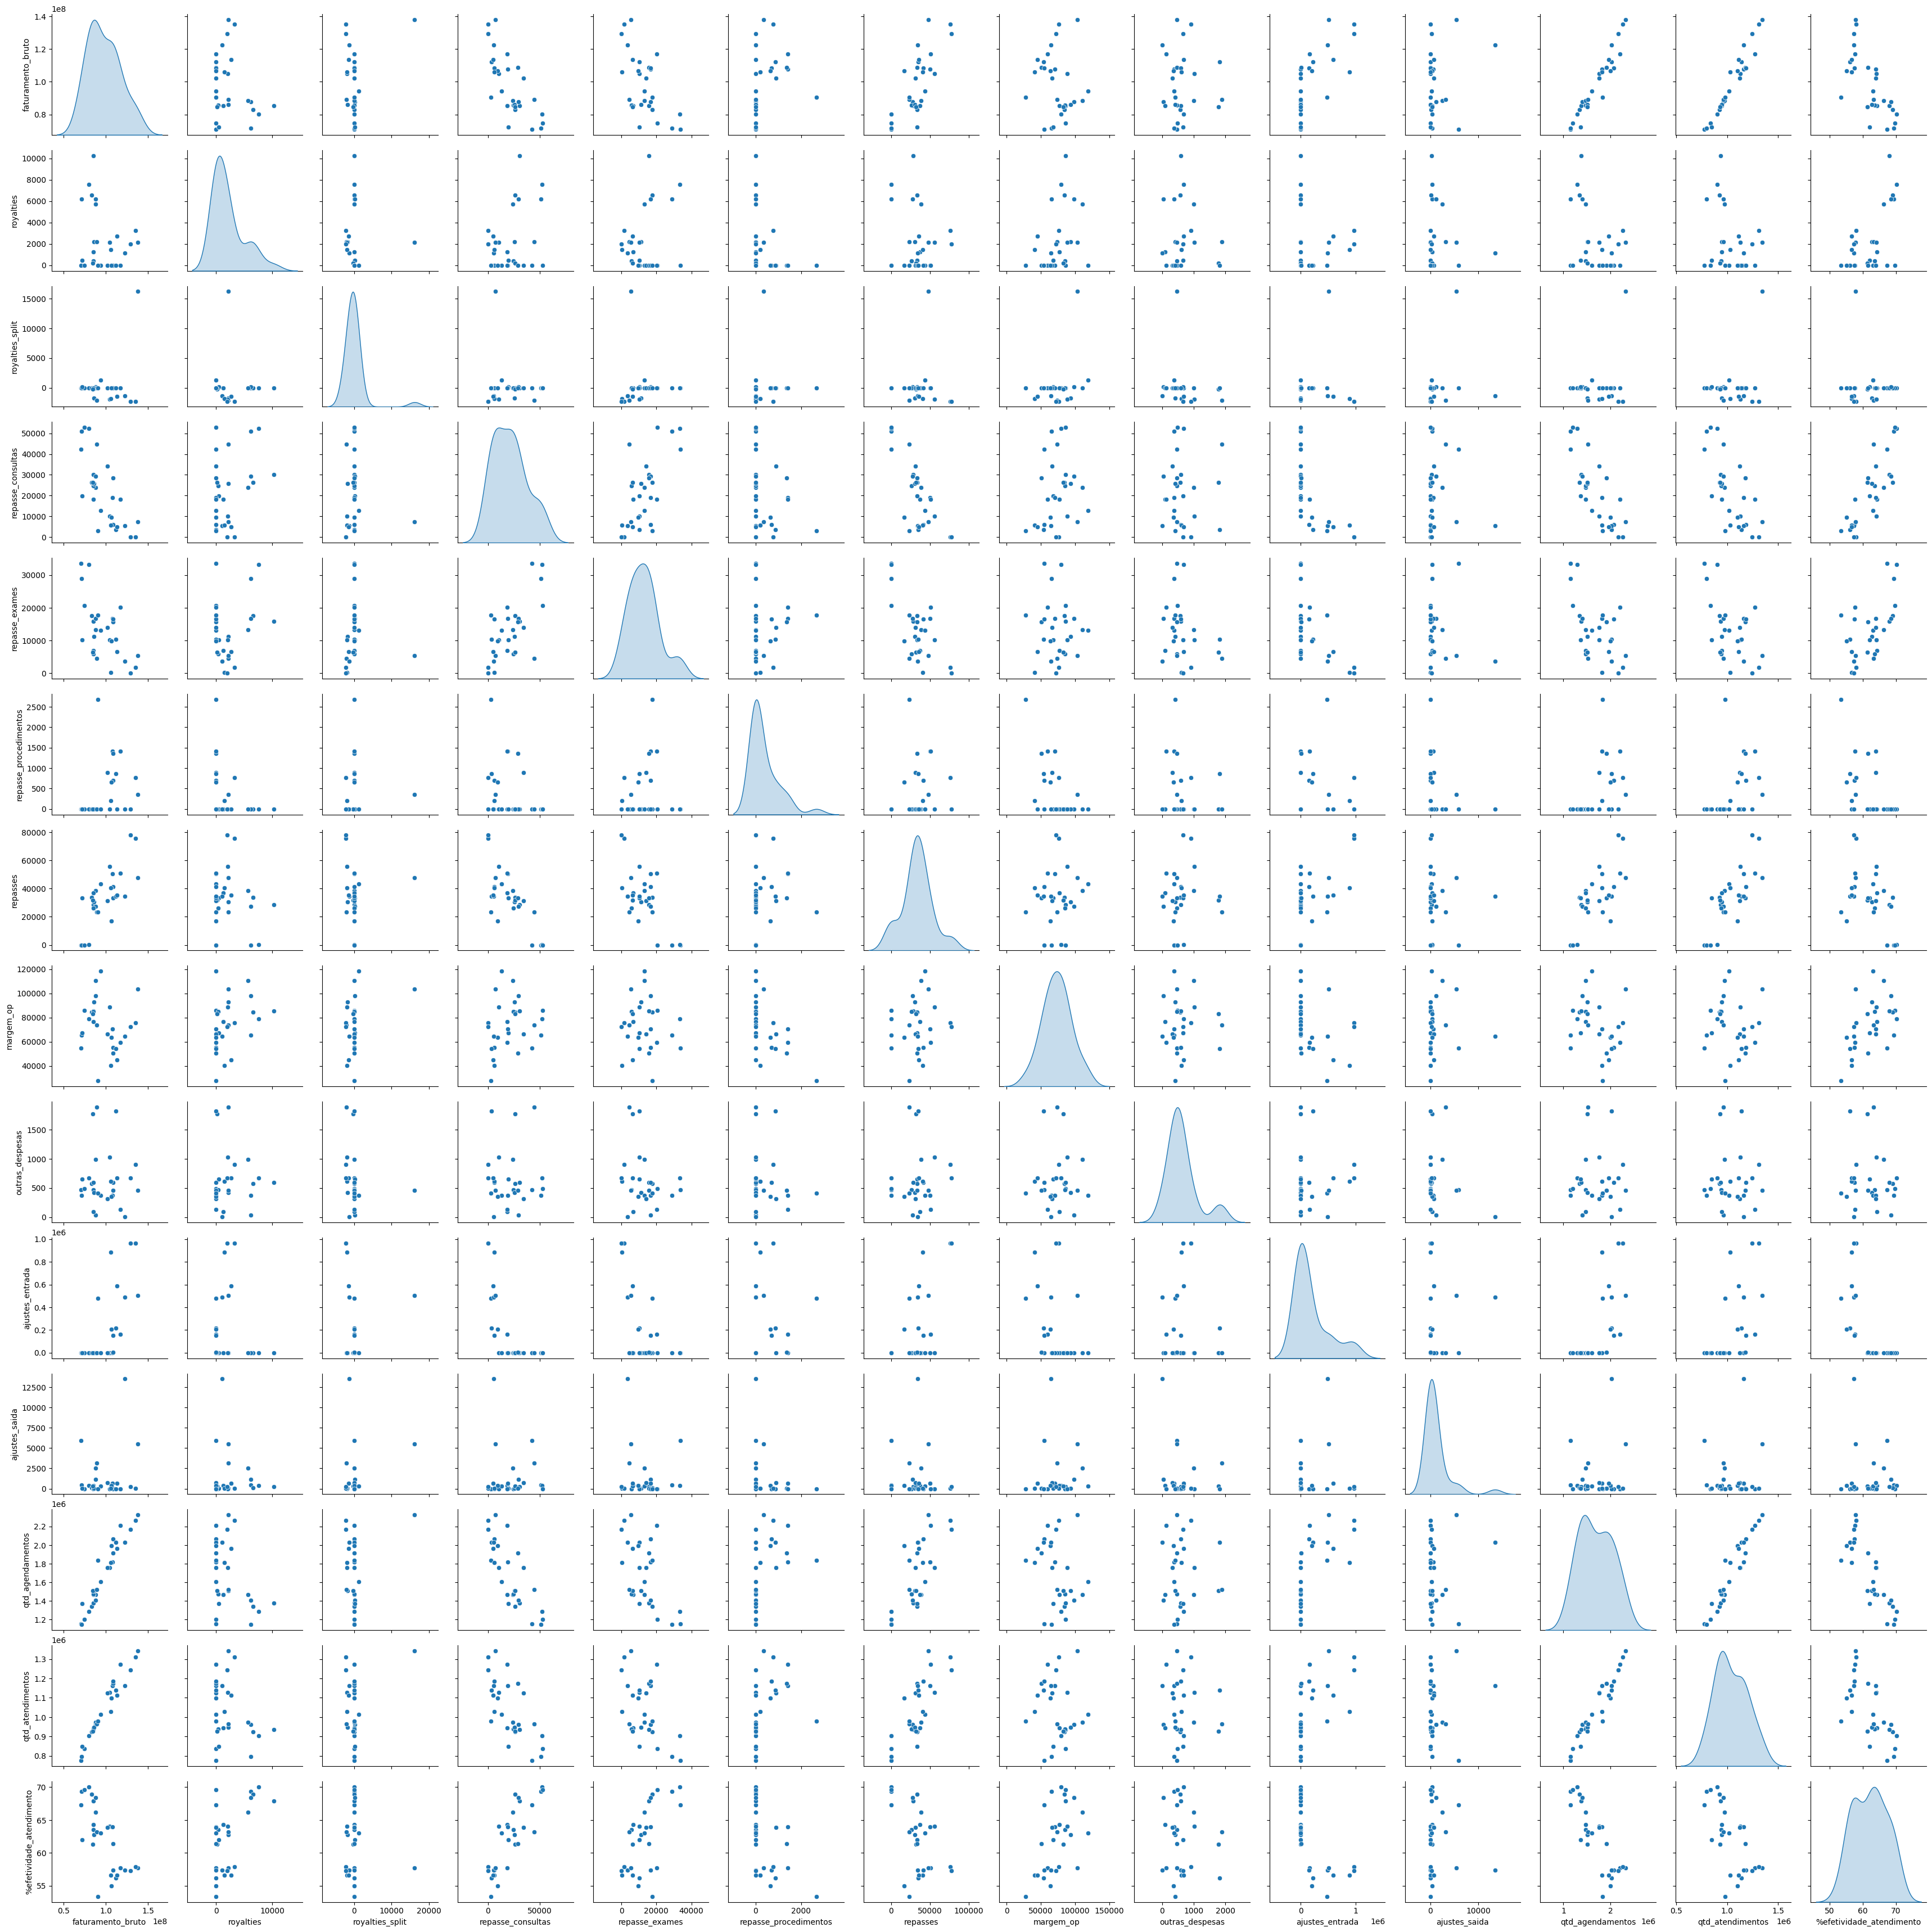

In [233]:
sns.pairplot(df_grouped.fillna(0),diag_kind="kde", 
                                        vars=['faturamento_bruto', 'royalties', 'royalties_split', 'repasse_consultas', 'repasse_exames', 'repasse_procedimentos', 
                                              'repasses', 'margem_op', 'outras_despesas', 'ajustes_entrada', 'ajustes_saida','qtd_agendamentos', 'qtd_atendimentos',
                                         '%efetividade_atendimento'])

In [234]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

In [235]:
#Separar as features (data e qtde_registro) e o target (total_recebido)
X = df_grouped[['qtd_agendamentos', 'qtd_atendimentos', 'repasse_consultas', 'repasse_exames', '%efetividade_atendimento']]
y = df_grouped['faturamento_bruto']
#há NaN nos dados, impossibilitando o algoritmo (substituindo vazios por 0)
X.fillna(0, inplace=True)

/tmp/ipykernel_1109/556987834.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


In [236]:
# Dividir o dataset em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [237]:
# Padronizar as features para terem média zero e desvio padrão um
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [238]:
# Criar e treinar o modelo de regressão com redes neurais
model = MLPRegressor(hidden_layer_sizes=(1000, 500, 400, 300, 200, 100, 25), 
                     activation='relu', solver='adam', random_state=None,
                     alpha=0.0001, batch_size='auto', learning_rate='constant',
                     learning_rate_init=0.001, power_t=0.5, max_iter=200,
                     shuffle=True,tol=0.0001,
                     verbose=False, warm_start=False, momentum=0.9,
                     nesterovs_momentum=True, early_stopping=False,
                     validation_fraction=0.1, beta_1=0.9, beta_2=0.999,
                     epsilon=1e-08, n_iter_no_change=10, max_fun=15000)

model.fit(X_train, y_train)



/home/gabriel/anaconda3/envs/.conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(hidden_layer_sizes=(1000, 500, 400, 300, 200, 100, 25))

In [239]:
y_pred = model.predict(X_test)

In [240]:
mse = mean_squared_error(y_test, y_pred)
print('Erro médio quadrático:', mse)

Erro médio quadrático: 91598224940709.17


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


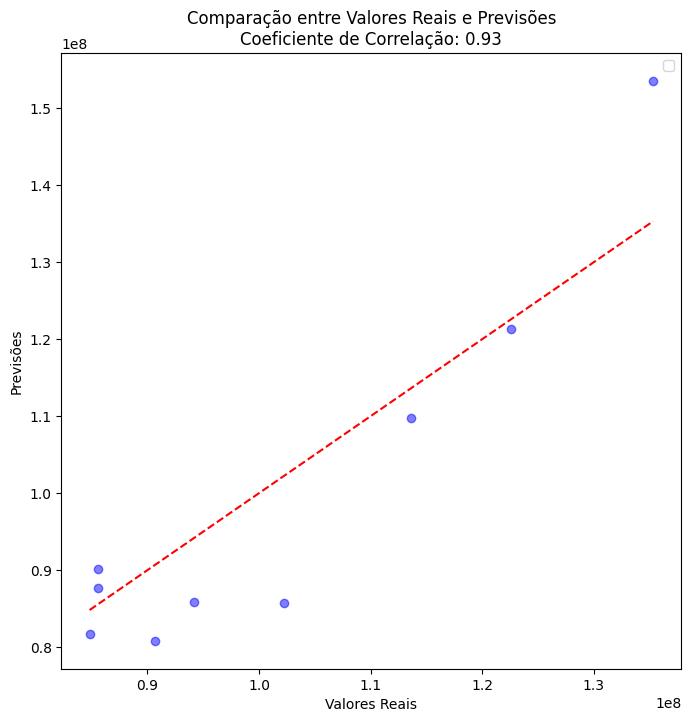

In [241]:
# Calcular o coeficiente de correlação
correlation = np.corrcoef(y_test, y_pred)[0, 1]

# Criar o gráfico de dispersão com linha de tendência
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, color='b', alpha=0.5)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='r', linestyle='--')
ax.set_xlabel('Valores Reais')
ax.set_ylabel('Previsões')
ax.set_title('Comparação entre Valores Reais e Previsões\nCoeficiente de Correlação: {:.2f}'.format(correlation))
ax.legend()
plt.show()

In [242]:
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = calculate_mape(y_test, y_pred)
print('Erro Percentual Absoluto Médio (MAPE): {:.2f}%'.format(mape))

Erro Percentual Absoluto Médio (MAPE): 7.25%


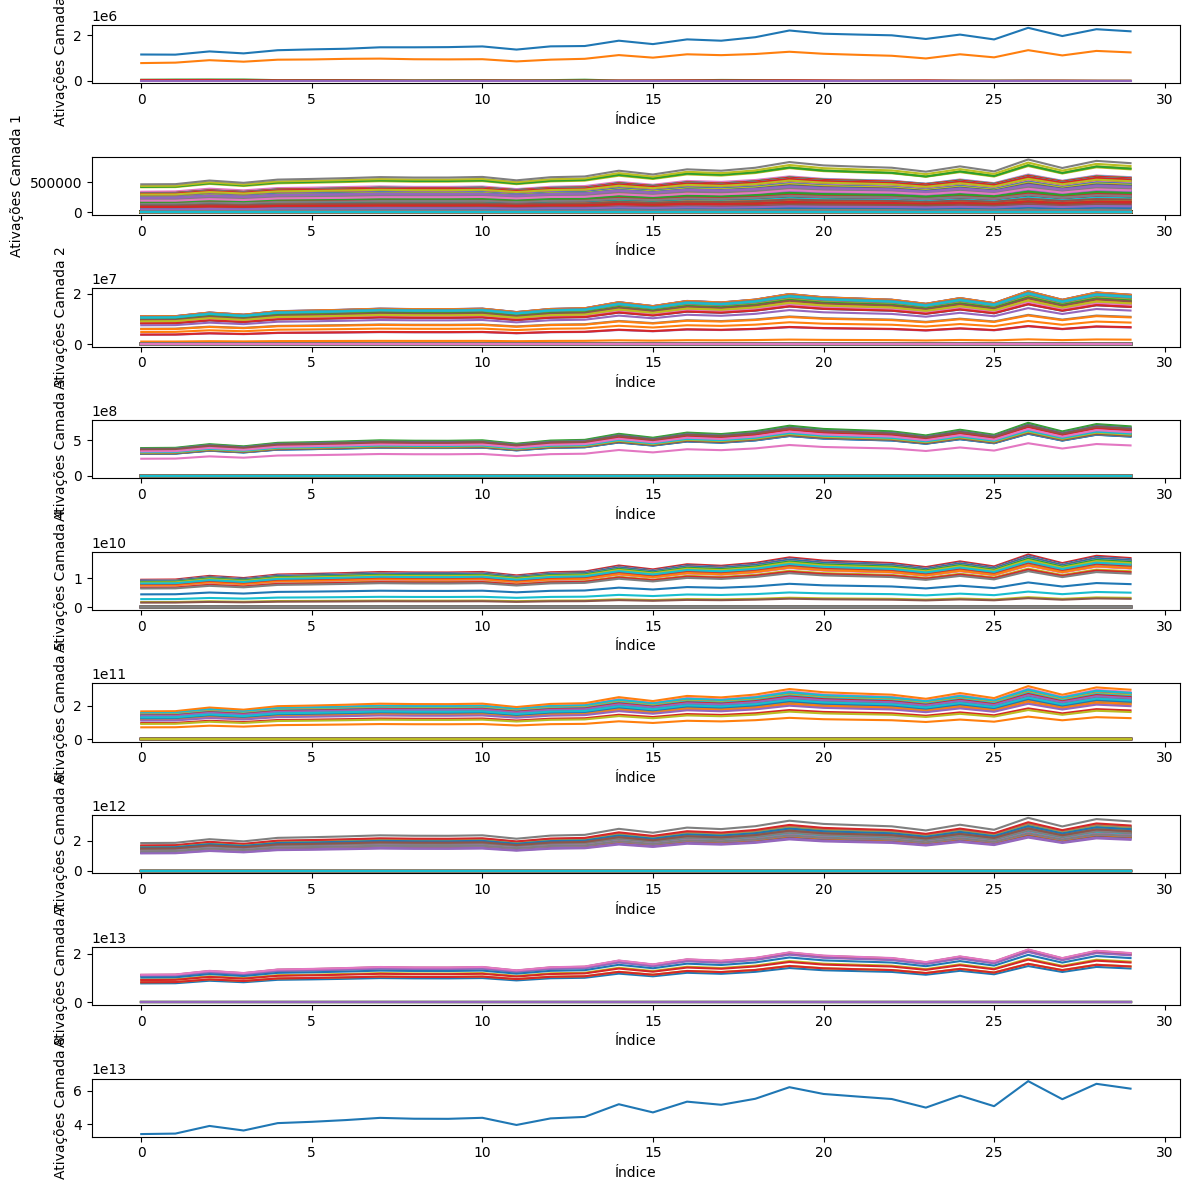

In [243]:
def get_activations(model, X):
    activations = [X]
    for i in range(len(model.coefs_)):
        activations.append(np.maximum(0, np.dot(activations[-1], model.coefs_[i]) + model.intercepts_[i]))
    return activations

activations = get_activations(model, X)

fig, ax = plt.subplots(len(model.coefs_) + 1, 1, figsize=(12, 12))
for i in range(len(model.coefs_) + 1):
    ax[i].plot(X.index, activations[i])
    ax[i].set_xlabel('Índice')
    ax[i].set_ylabel(f'Ativações Camada {i}')
plt.tight_layout()
plt.show()

In [244]:
model.fit(X_train, y_train)

/home/gabriel/anaconda3/envs/.conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(hidden_layer_sizes=(1000, 500, 400, 300, 200, 100, 25))

In [245]:
parametros = model.coefs_
for i, param in enumerate(parametros):
    print(f'Camada {i+1}: {param.shape}') # Exibe a forma da matriz de pesos

Camada 1: (5, 1000)
Camada 2: (1000, 500)
Camada 3: (500, 400)
Camada 4: (400, 300)
Camada 5: (300, 200)
Camada 6: (200, 100)
Camada 7: (100, 25)
Camada 8: (25, 1)


Tentativa com o Prophet do facebook

In [246]:
#pip install prophet

In [247]:
from prophet import Prophet

In [248]:
df_grouped_index = df_grouped.reset_index()
df_grouped_index.head(5)

,index,data_x,faturamento_bruto,royalties,royalties_split,repasse_consultas,repasse_exames,repasse_procedimentos,repasses,margem_op,...,outras_despesas,resultado_exercicio,receita_socios,despesa_socios,ajustes_entrada,ajustes_saida,resultado_liquido,qtd_agendamentos,qtd_atendimentos,%efetividade_atendimento
0,0,2021-01-01,70922868.58,0.00,0.0,42417.79,33614.48,0.0,0.0,54838.45,...,466.0,1880977.64,484543.47,0.00,0.00,5928.54,2359592.57,1152865,775894.0,67.301375
1,1,2021-02-01,71646457.95,6185.92,0.0,50996.36,28994.51,0.0,0.0,65235.65,...,376.9,1459828.26,1147531.04,0.00,616.73,431.67,2607544.36,1146604,795443.0,69.373820
2,2,2021-03-01,80360626.51,7574.07,0.0,52333.00,33296.28,0.0,150.0,79035.33,...,673.0,1702486.41,975450.91,0.00,0.00,400.00,2677537.32,1288682,903081.0,70.077878
3,3,2021-04-01,74712521.62,0.00,0.0,52837.00,20629.77,0.0,0.0,85802.08,...,488.5,2226575.18,1194410.23,70.00,0.00,0.00,3420915.41,1201836,836963.0,69.640367
4,4,2021-05-01,83091517.26,6563.09,0.0,26202.00,17531.50,0.0,33679.5,84287.01,...,580.0,1479950.32,1120101.54,18540.78,0.00,120.00,2581391.08,1341137,924948.0,68.967451


In [249]:
df3 = df_grouped_index[['data_x', 'faturamento_bruto']]
df3.columns = ['ds', 'y']

In [250]:
df_index = df_grouped_index.set_index('data_x', inplace=True)

In [251]:
model = Prophet()
model.fit(df3)

15:50:05 - cmdstanpy - INFO - Chain [1] start processing
15:50:05 - cmdstanpy - INFO - Chain [1] done processing


In [252]:
future = model.make_future_dataframe(periods=12, freq='MS')  # Prever os próximos 12 meses

In [253]:
forecast = model.predict(future)

In [254]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-01,6.977114e+07,6.558991e+07,6.965424e+07,6.977114e+07,6.977114e+07,-2.149610e+06,-2.149610e+06,-2.149610e+06,-2.149610e+06,-2.149610e+06,-2.149610e+06,0.0,0.0,0.0,6.762153e+07
1,2021-02-01,7.129975e+07,7.051895e+07,7.455060e+07,7.129975e+07,7.129975e+07,1.187020e+06,1.187020e+06,1.187020e+06,1.187020e+06,1.187020e+06,1.187020e+06,0.0,0.0,0.0,7.248677e+07
2,2021-03-01,7.268043e+07,7.789809e+07,8.193462e+07,7.268043e+07,7.268043e+07,7.220665e+06,7.220665e+06,7.220665e+06,7.220665e+06,7.220665e+06,7.220665e+06,0.0,0.0,0.0,7.990110e+07
3,2021-04-01,7.420904e+07,7.382906e+07,7.798740e+07,7.420904e+07,7.420904e+07,1.751401e+06,1.751401e+06,1.751401e+06,1.751401e+06,1.751401e+06,1.751401e+06,0.0,0.0,0.0,7.596044e+07
4,2021-05-01,7.568834e+07,8.197861e+07,8.620598e+07,7.568834e+07,7.568834e+07,8.326548e+06,8.326548e+06,8.326548e+06,8.326548e+06,8.326548e+06,8.326548e+06,0.0,0.0,0.0,8.401489e+07
5,2021-06-01,7.721905e+07,8.274747e+07,8.702786e+07,7.721905e+07,7.721905e+07,7.759054e+06,7.759054e+06,7.759054e+06,7.759054e+06,7.759054e+06,7.759054e+06,0.0,0.0,0.0,8.497811e+07
6,2021-07-01,7.870324e+07,8.697457e+07,9.100886e+07,7.870324e+07,7.870324e+07,1.037930e+07,1.037930e+07,1.037930e+07,1.037930e+07,1.037930e+07,1.037930e+07,0.0,0.0,0.0,8.908254e+07
7,2021-08-01,8.024132e+07,8.705763e+07,9.122339e+07,8.024132e+07,8.024132e+07,8.864227e+06,8.864227e+06,8.864227e+06,8.864227e+06,8.864227e+06,8.864227e+06,0.0,0.0,0.0,8.910554e+07
8,2021-09-01,8.178335e+07,8.374062e+07,8.777088e+07,8.178335e+07,8.178335e+07,3.970857e+06,3.970857e+06,3.970857e+06,3.970857e+06,3.970857e+06,3.970857e+06,0.0,0.0,0.0,8.575421e+07
9,2021-10-01,8.327781e+07,8.304524e+07,8.712459e+07,8.327781e+07,8.327781e+07,1.898617e+06,1.898617e+06,1.898617e+06,1.898617e+06,1.898617e+06,1.898617e+06,0.0,0.0,0.0,8.517642e+07


In [255]:
ultima_previsao = print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12))  # Últimas 12 previsões

           ds          yhat    yhat_lower    yhat_upper
30 2023-07-01  1.297586e+08  1.276656e+08  1.316649e+08
31 2023-08-01  1.469856e+08  1.448675e+08  1.490491e+08
32 2023-09-01  1.335565e+08  1.314483e+08  1.358333e+08
33 2023-10-01  1.418265e+08  1.398952e+08  1.438736e+08
34 2023-11-01  1.312178e+08  1.290933e+08  1.334131e+08
35 2023-12-01  1.136045e+08  1.114786e+08  1.156971e+08
36 2024-01-01  1.509565e+08  1.487336e+08  1.531074e+08
37 2024-02-01  1.292754e+08  1.271189e+08  1.314759e+08
38 2024-03-01  1.447200e+08  1.424984e+08  1.468885e+08
39 2024-04-01  1.515030e+08  1.493459e+08  1.537985e+08
40 2024-05-01  1.542002e+08  1.518872e+08  1.565752e+08
41 2024-06-01  1.602715e+08  1.577119e+08  1.626589e+08


In [256]:
# Transformar valores em notação científica para decimal
forecast1[['yhat', 'yhat_lower', 'yhat_upper']] = forecast[['yhat', 'yhat_lower', 'yhat_upper']].apply(lambda x: x.apply('{:.8f}'.format))

In [257]:
forecast1

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-01,6.977114e+07,65589911.53405518,69654241.21910314,6.977114e+07,6.977114e+07,-2.149610e+06,-2.149610e+06,-2.149610e+06,-2.149610e+06,-2.149610e+06,-2.149610e+06,0.0,0.0,0.0,67621529.10233118
1,2021-02-01,7.129975e+07,70518951.00160879,74550596.80450076,7.129975e+07,7.129975e+07,1.187020e+06,1.187020e+06,1.187020e+06,1.187020e+06,1.187020e+06,1.187020e+06,0.0,0.0,0.0,72486770.17876360
2,2021-03-01,7.268043e+07,77898090.57493663,81934622.32148460,7.268043e+07,7.268043e+07,7.220665e+06,7.220665e+06,7.220665e+06,7.220665e+06,7.220665e+06,7.220665e+06,0.0,0.0,0.0,79901095.71958426
3,2021-04-01,7.420904e+07,73829055.19004206,77987404.57300867,7.420904e+07,7.420904e+07,1.751401e+06,1.751401e+06,1.751401e+06,1.751401e+06,1.751401e+06,1.751401e+06,0.0,0.0,0.0,75960442.00776365
4,2021-05-01,7.568834e+07,81978612.69795196,86205980.51750940,7.568834e+07,7.568834e+07,8.326548e+06,8.326548e+06,8.326548e+06,8.326548e+06,8.326548e+06,8.326548e+06,0.0,0.0,0.0,84014889.94457938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1105,2026-05-12,2.007198e+08,NaN,NaN,1.952544e+08,2.058348e+08,-8.846603e+07,-8.846603e+07,-8.846603e+07,-8.846603e+07,-8.846603e+07,-8.846603e+07,0.0,0.0,0.0,NaN
1106,2026-05-13,2.007907e+08,NaN,NaN,1.953132e+08,2.059100e+08,-9.432350e+07,-9.432350e+07,-9.432350e+07,-9.432350e+07,-9.432350e+07,-9.432350e+07,0.0,0.0,0.0,NaN
1107,2026-05-14,2.008616e+08,NaN,NaN,1.953721e+08,2.059852e+08,-9.908038e+07,-9.908038e+07,-9.908038e+07,-9.908038e+07,-9.908038e+07,-9.908038e+07,0.0,0.0,0.0,NaN
1108,2026-05-15,2.009324e+08,NaN,NaN,1.954313e+08,2.060605e+08,-1.026291e+08,-1.026291e+08,-1.026291e+08,-1.026291e+08,-1.026291e+08,-1.026291e+08,0.0,0.0,0.0,NaN


In [258]:
caminho_arquivo = 'meucsv.csv'

# Exportar o DataFrame para um arquivo CSV
forecast1.to_csv(caminho_arquivo, index=False)

In [259]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calcular as previsões do modelo
y_pred = forecast['yhat'].tail(len(y_test))  # Usar as previsões correspondentes ao conjunto de teste

# Calcular as métricas de desempenho
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Exibir as métricas
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("MAPE:", mape)

MAE: 40321456.70457402
MSE: 1935655213290864.8
RMSE: 43996081.79475605
MAPE: nan


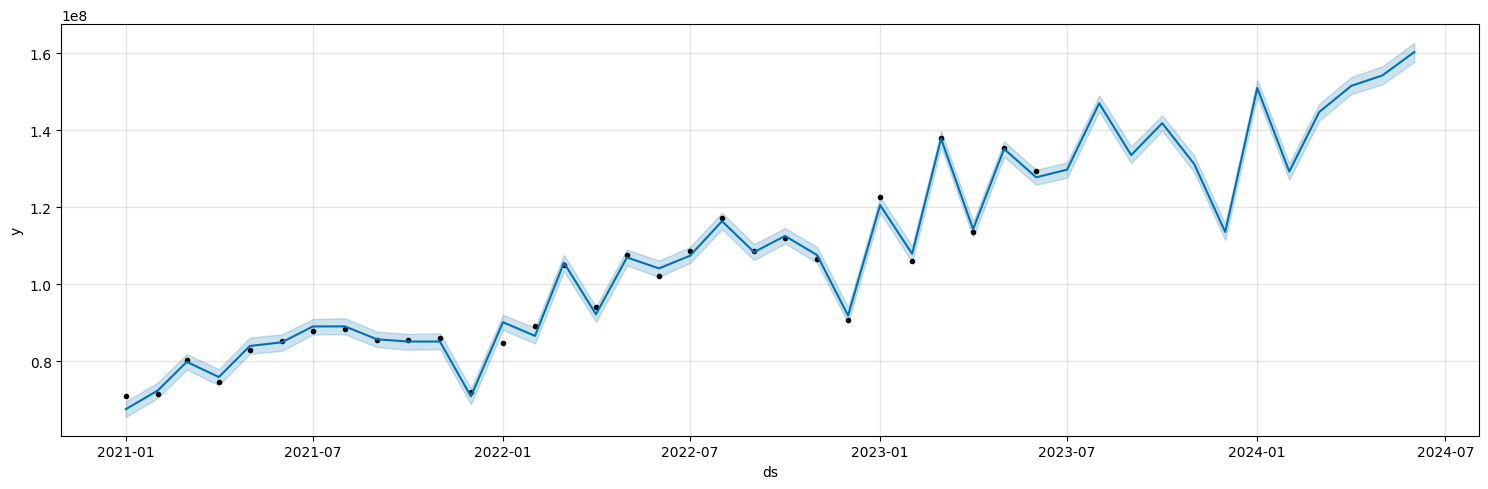

In [260]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(forecast,
                 ax=ax)
plt.show()

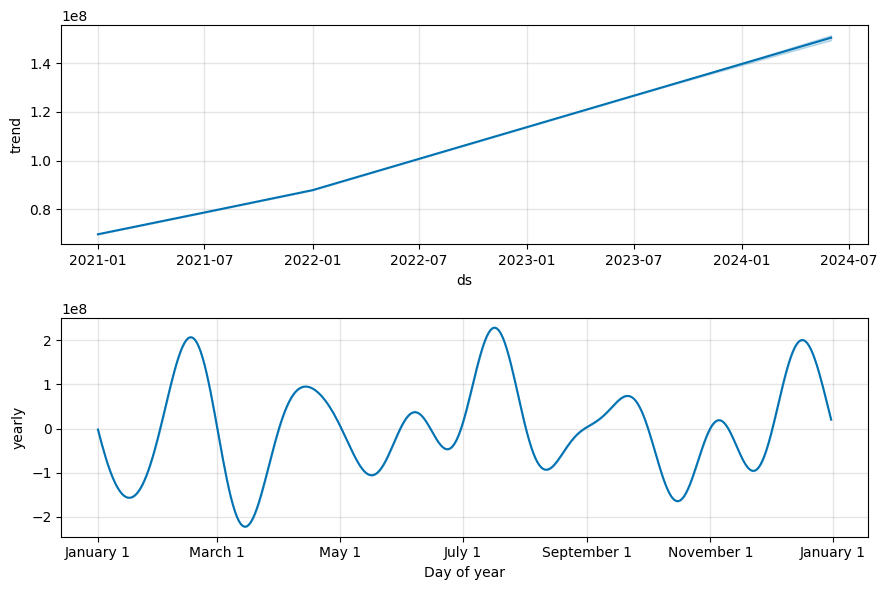

In [261]:
model.plot_components(forecast);

15:50:06 - cmdstanpy - INFO - Chain [1] start processing


15:50:06 - cmdstanpy - INFO - Chain [1] done processing


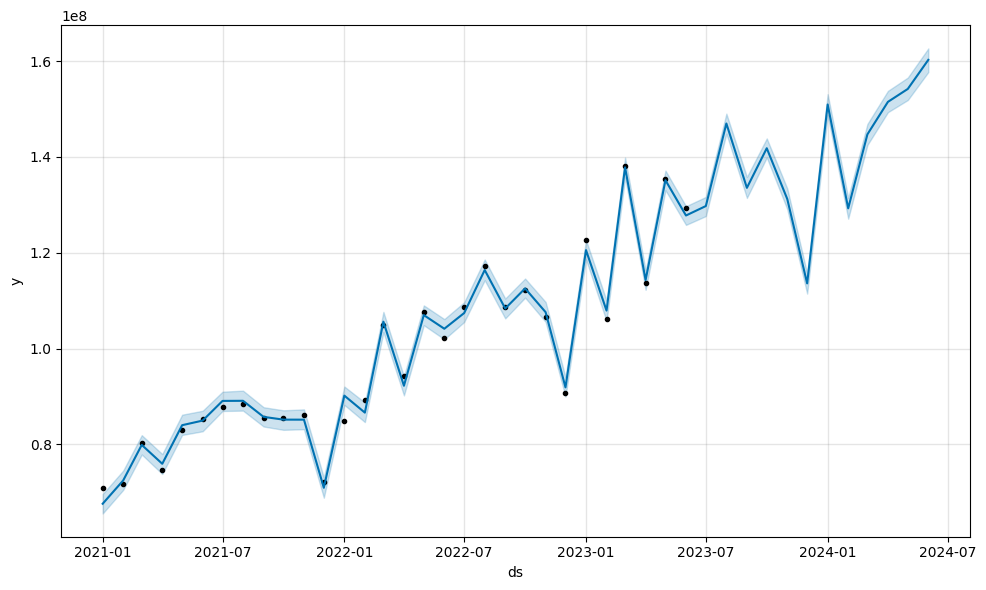

In [262]:
m = Prophet()
m.fit(df3)
future = m.make_future_dataframe(periods=1080)
forecast1 = m.predict(future)
fig = m.plot(forecast)